In [13]:
import pymc as pm
import arviz as az
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_BDS = '../bds/'

# DEFININDO UMA LISTA COM OS NOMES DAS AÇÕES QUE ESTAMOS UTILIZANDO
data_names = ['TSLA']

In [14]:
# DICIONARIO DE SÉRIES TEMPORAIS
times_series = {}
for name in data_names:
    times_series[name] = pd.read_csv(DATA_PATH_BDS + name + '.csv',sep=',')

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

def calcular_metricas_regressao(y_true, y_pred):
    # Certifique-se de que y_true e y_pred são arrays de uma única dimensão
    y_true = np.array(y_true).flatten()  
    y_pred = np.array(y_pred).flatten()
    
    # Calcula as métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Raiz do MSE
    mape = tss.mape(y_true, y_pred)
    theil = tss.theil(y_true, y_pred)
    arv = tss.arv(y_true, y_pred)
    wpocid = tss.wpocid(y_true, y_pred)
    
    # Verifica se há mais de um ponto para calcular o R²
    if len(y_true) > 1:
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))  # Coeficiente de determinação
    else:
        r2 = 'N/A'  # Não aplicável para previsões de um único ponto
    
    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['MAE', 'MSE', 'MAPE','RMSE', 'R²','THEIL','ARV','WPOCID'],
        'Valor': [mae, mse, mape, rmse, r2, theil, arv, wpocid]
    })
    
    return metrics_df

In [16]:
for name in data_names:
    times_series[name] = times_series[name][['Date','Close']]

In [17]:
def get_lags_significants(target, n_lags = 5, alpha = 0.05):
    pac, pac_ci = sm.tsa.pacf(x = target, nlags = n_lags, alpha=alpha)
    pd.DataFrame(pac)[1:].plot(kind='bar', legend='pacf',
                               xlabel='lag', ylabel='pacf');
    sm.graphics.tsa.plot_pacf(target, lags=n_lags)
    significantLags = []
    for i in range(1, len(pac)):
        if pac[i] < pac_ci[i][0] - pac[i] or pac[i] > pac_ci[i][1] - pac[i]:
            significantLags.append(i)
    print('significantLags:', significantLags)
    return significantLags

def get_all_lags_significants(data, var_names, qtd_lags):
    significants_lags = {}
    # Itera sobre as variáveis e suas respectivas quantidades de lags
    for name, lags in zip(var_names, qtd_lags):
        significants_lags[name] = get_lags_significants(data[name]['Close'], lags)
        
    
    return significants_lags

significantLags: [1, 5, 8, 10]


{'TSLA': [1, 5, 8, 10]}

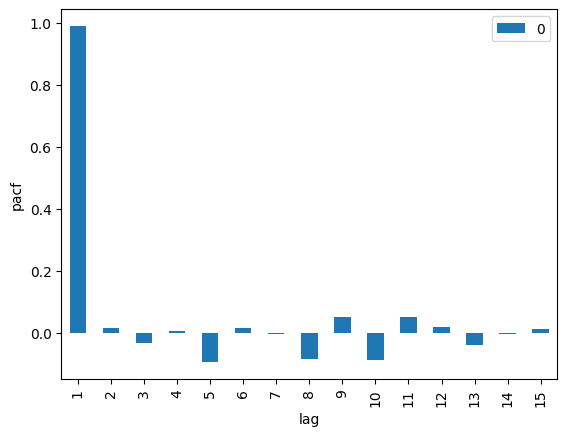

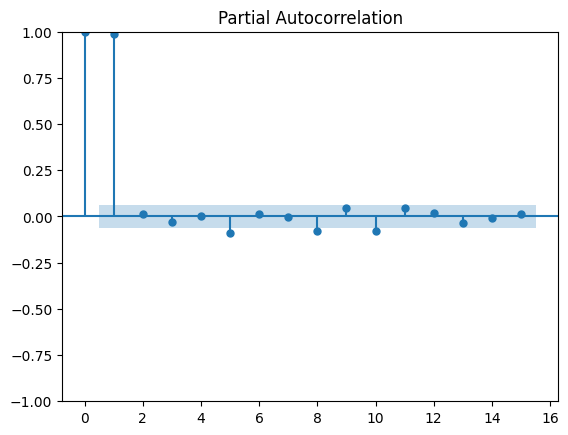

In [18]:
qtd_lags = [15,10,10,10]
all_significants_lags = get_all_lags_significants(times_series, data_names, qtd_lags)
all_significants_lags

In [19]:
def appendLagVariables(yNm, significantLags, df, dropna=True):
    prefix = yNm.replace(')', '')
    df = df.copy()
    for lag in significantLags:
        varNm = '('+prefix+'-'+str(lag)+')'
        # nDj = pd.concat([nDj, nDj[['e1(t)']].shift(lag)], axis=1)
        df[varNm] = df[yNm].shift(lag)
        # nDj.columns = nDj.columns + [varNm]
    if dropna:
        df.dropna(axis=0, inplace=True)
    display(df.head(2))
    return df
"""TM_tesla = appendLagVariables(yNm='Close', 
                         significantLags = e1_significantLags, 
                         df = TM_tesla, 
                         dropna=True)"""

"TM_tesla = appendLagVariables(yNm='Close', \n                         significantLags = e1_significantLags, \n                         df = TM_tesla, \n                         dropna=True)"

In [20]:
times_series_with_lags = {}
for name in data_names:
    times_series_with_lags[name] = appendLagVariables(
        yNm='Close',
        significantLags=all_significants_lags[name],
        df = times_series[name]
    )

,Date,Close,(Close-1),(Close-5),(Close-8),(Close-10)
10,2020-09-16,147.253326,149.919998,122.093330,135.666672,158.350006
11,2020-09-17,141.143326,147.253326,123.779999,139.440002,149.123337


In [21]:
data_train = {}
data_test= {}
for name in data_names:
    data_train[name], data_test[name] = train_test_split(times_series_with_lags[name], test_size=0.2, shuffle=False)

In [22]:
from sklearn.linear_model import LinearRegression


In [23]:
data_train['TSLA'][['(Close-1)','(Close-5)','(Close-8)','(Close-10)']]

,(Close-1),(Close-5),(Close-8),(Close-10)
10,149.919998,122.093330,135.666672,158.350006
11,147.253326,123.779999,139.440002,149.123337
12,141.143326,124.239998,110.070000,135.666672
13,147.383331,139.873337,122.093330,139.440002
14,149.796661,149.919998,123.779999,110.070000
...,...,...,...,...
801,219.270004,200.839996,205.759995,216.520004
802,222.179993,205.660004,207.300003,212.419998
803,222.110001,218.509995,197.360001,205.759995
804,209.979996,219.960007,200.839996,207.300003


In [24]:
"""X = np.arange(len(data_train['TSLA']))  
y = data_train['TSLA']['Close'].values  # Observações

reg = LinearRegression().fit(data_train['TSLA'][['(Close-1)','(Close-5)','(Close-8)','(Close-10)']], data_train['TSLA']['Close'])  # Regressão linear simples para calcular coeficiente inicial
slope_prior = reg.coef_[0]
intercept_prior = reg.intercept_
sigma_prior = np.std(y - reg.predict(data_train['TSLA'][['(Close-1)','(Close-5)','(Close-8)','(Close-10)']]))  # Desvio padrão dos resíduos

# Modelo de regressão linear Bayesiana
with pm.Model() as model:
    intercept = pm.Normal("intercept", mu=intercept_prior, sigma=10)  # Prior para o intercepto 
    slope = pm.Normal("slope", mu=slope_prior, sigma=10)  # Prior para o coeficiente com base na regressão linear simples
    sigma = pm.HalfNormal("sigma", sigma=sigma_prior)  # Prior para o erro com base no desvio padrão residual

    # Likelihood (verossimilhança)
    mu = intercept + slope * X.flatten()  # Predição da regressão linear
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)  # Dados observados

    # Inferência por amostragem (NUTS sampler)
    trace = pm.sample(1000, return_inferencedata=True)"""

'X = np.arange(len(data_train[\'TSLA\']))  # Use o comprimento da série de dados como o eixo X\ny = data_train[\'TSLA\'][\'Close\'].values  # Observações\n\nreg = LinearRegression().fit(data_train[\'TSLA\'][[\'(Close-1)\',\'(Close-5)\',\'(Close-8)\',\'(Close-10)\']], data_train[\'TSLA\'][\'Close\'])  # Regressão linear simples para calcular coeficiente inicial\nslope_prior = reg.coef_[0]\nintercept_prior = reg.intercept_\nsigma_prior = np.std(y - reg.predict(data_train[\'TSLA\'][[\'(Close-1)\',\'(Close-5)\',\'(Close-8)\',\'(Close-10)\']]))  # Desvio padrão dos resíduos\n\n# Modelo de regressão linear Bayesiana\nwith pm.Model() as model:\n    intercept = pm.Normal("intercept", mu=intercept_prior, sigma=10)  # Prior para o intercepto \n    slope = pm.Normal("slope", mu=slope_prior, sigma=10)  # Prior para o coeficiente com base na regressão linear simples\n    sigma = pm.HalfNormal("sigma", sigma=sigma_prior)  # Prior para o erro com base no desvio padrão residual\n\n    # Likelihood (ve

O Bayesian Ridge Regression é uma abordagem bayesiana para a regressão linear que assume uma distribuição probabilística sobre os coeficientes do modelo, ao contrário da regressão tradicional. Ele é útil para evitar o overfitting, já que incorpora regularização na forma de uma distribuição normal sobre os parâmetros.

In [41]:
X_train

,Date,Close,(Close-1),(Close-5),(Close-8),(Close-10)
806,2023-11-14,237.410004,223.710007,222.179993,218.509995,200.839996
807,2023-11-15,242.839996,237.410004,222.110001,219.960007,205.660004
808,2023-11-16,233.589996,242.839996,209.979996,219.270004,218.509995
809,2023-11-17,234.300003,233.589996,214.649994,222.179993,219.960007
810,2023-11-20,235.600006,234.300003,223.710007,222.110001,219.270004
...,...,...,...,...,...,...
1001,2024-08-26,213.210007,220.320007,222.720001,201.380005,197.490005
1002,2024-08-27,209.210007,213.210007,221.100006,214.139999,207.830002
1003,2024-08-28,205.750000,209.210007,223.270004,216.119995,201.380005
1004,2024-08-29,206.279999,205.750000,210.660004,222.720001,214.139999


In [43]:
X_train = data_train['TSLA'][['(Close-1)','(Close-5)','(Close-8)','(Close-10)']]
y_train = data_train['TSLA']['Close']
X_test = data_test['TSLA'][['(Close-1)','(Close-5)','(Close-8)','(Close-10)']]
y_test = data_test['TSLA']['Close']

In [44]:
from sklearn.linear_model import BayesianRidge

model = BayesianRidge()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [47]:
calcular_metricas_regressao(y_test, y_pred)

,Métrica,Valor
0,MAE,5.086068
1,MSE,49.087574
2,MAPE,2.533441
3,RMSE,7.006252
4,R²,0.946288
5,THEIL,0.992739
6,ARV,0.053712
7,WPOCID,0.527638


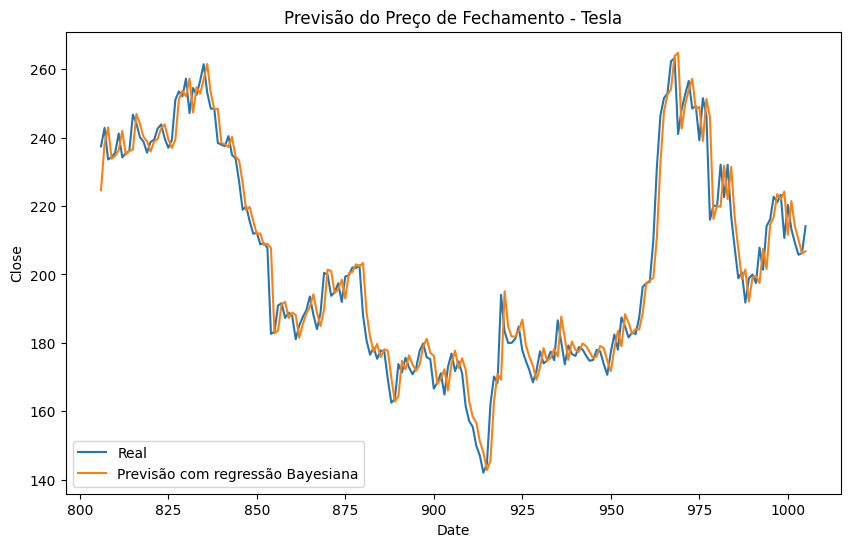

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(data_test['TSLA'].index, y_test, label='Real')
plt.plot(data_test['TSLA'].index, y_pred, label='Previsão com regressão Bayesiana')
plt.title('Previsão do Preço de Fechamento - Tesla')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


Regressão Linear Bayeseana Online com River

In [50]:
from river import linear_model

In [64]:
X_train_dict = X_train.to_dict(orient='records')
X_test_dict = X_test.to_dict(orient='records')

In [65]:
model_on = linear_model.BayesianLinearRegression()

for i in range(len(X_train)):
    model_on.learn_one(X_train_dict[i], y_train.iloc[i])

previsoes = []

for i in range(len(X_test)):
    y_pred = model_on.predict_one(X_test_dict[i])
    previsoes.append(y_pred)
    model_on.learn_one(X_test_dict[i], y_test.iloc[i])

In [67]:
calcular_metricas_regressao(y_test, previsoes)

,Métrica,Valor
0,MAE,5.088846
1,MSE,49.497677
2,MAPE,2.521823
3,RMSE,7.035459
4,R²,0.945839
5,THEIL,0.999528
6,ARV,0.054161
7,WPOCID,0.527638


**OBSERVAÇÕES**

O R² alto (0.9458) e o ARV muito baixo (0.0541) indicam que o modelo está explicando bem a variabilidade dos dados.

O MAE e o RMSE mostram que o erro médio é relativamente moderado (erro de aproximadamente 5 a 7 unidades).

No entanto, o Theil's U elevado (0.9995) sugere que as previsões são semelhantes a um modelo simples de "não mudança", o que pode indicar que, apesar da boa performance geral, há espaço para melhorias no comportamento preditivo.

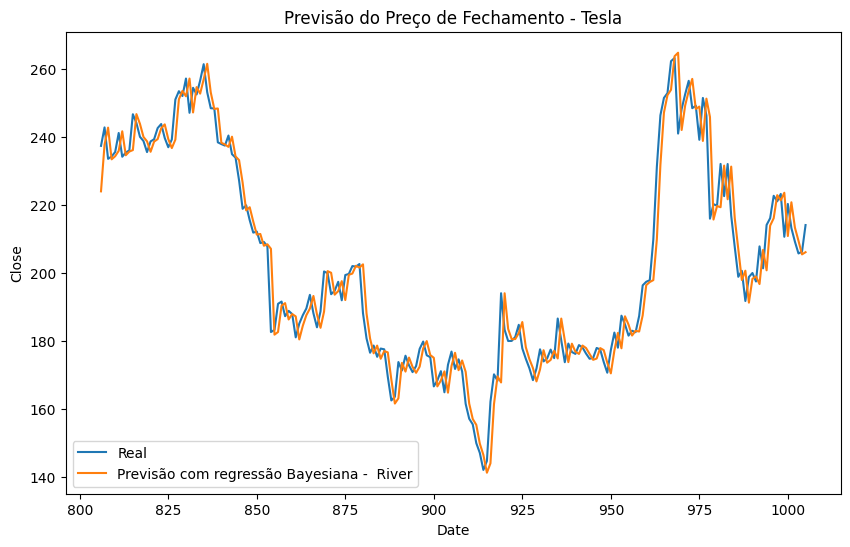

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(data_test['TSLA'].index, y_test, label='Real')
plt.plot(data_test['TSLA'].index, previsoes, label='Previsão com regressão Bayesiana -  River')
plt.title('Previsão do Preço de Fechamento - Tesla')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()
